This notebook aims to contain all the functions that will permit to apply bias correction.

TO DO :

NEED TO CHECK FUNCTIONALITY OF THE CODE for other methods than bscd precipitation
apply cdf for quantile ..
impose a version for the past and for the future (without y test, not used for BC, just for presentation of results)

In [1]:
# funciton to calculte return period

from scipy import stats
from scipy.stats import gumbel_r
from scipy.stats import gumbel_l

# function qui marche pour precipitation return period


def threshold_coresponding_to_return_period(loc,scale,T):
    p_non_exceedance = 1 - (1/T)
    try:
        threshold_coresponding = round(gumbel_r.ppf(p_non_exceedance,loc,scale))
    except OverflowError: # the result is not finite
        if math.isinf(gumbel_r.ppf(p_non_exceedance,loc,scale)) and gumbel_r.ppf(p_non_exceedance,loc,scale)<0:
            # ppf is the inverse of cdf
            # the result is -inf
            threshold_coresponding = 0 # the value of wero is imposed
    return threshold_coresponding

from Functions_Indicators import add_year_month_season # need to add conversion of time

# BIAS CORRECTION - POINT WISE METHOD

[Scikit-downscale](https://github.com/pangeo-data/scikit-downscale/tree/main)
[Detailed process here](https://github.com/pangeo-data/scikit-downscale/blob/main/examples/2020ECAHM-scikit-downscale.ipynb)

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
import scipy
import xarray as xr
import os
import os.path

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns



# exploratory data analysis for arrm model
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
# train_test_split Quick utility that wraps input validation and
#    ``next(ShuffleSplit().split(X, y))`` and application to input data
#    into a single call for splitting (and optionally subsampling) data in a
#    oneliner.
#    Returns
#    -------
#    splitting : list, length=2 * len(arrays)
#        List containing train-test split of inputs.

#        .. versionadded:: 0.16
#            If the input is sparse, the output will be a
#            ``scipy.sparse.csr_matrix``. Else, output type is the same as the
#            input type.

#from utils import get_sample_data

from sklearn.preprocessing import KBinsDiscretizer
# use for discretization

sns.set(style='darkgrid')

In [19]:
# df_obs and df_model should be under a dataframe format, with no nan values, with a common timelaps, with the data as a string format '%Y-%m-%d', and as index

# Method could be :
#        piecewise_regressor
#        Quantile_Linear_Regression

def BC(name_station, df_obs, name_column_df_obs,df_model, name_column_df_model,method):
    # prepare data
    training = df_model.copy(deep=True).rename(columns = {'Date':'time',name_column_df_model:'pcp'}).reset_index()
    targets = df_obs.copy(deep=True)
    training = training[training['Name station']==name_station]
    training = training[['time','pcp']]
    # changing format of Date for training
    Date1 = training['time'].values
    for i in np.arange(0,len(training)):
        training['time'].iloc[i] = Date1[i][6:10]+'-'+Date1[i][3:5]+'-'+Date1[i][0:2]#datetime.strptime(, '%Y-%M-%d').date()
        #print(training['time'].iloc[i])
    # .date() to avoid having the hours in the datetime
    training=training.set_index('time')


    # targets
    targets = targets[['NAME','DATE','PRCP']] # select only 3 columns of interest
    targets = targets[targets['NAME']==name_station].rename(columns = {'DATE':'time',name_column_df_obs:'pcp'}).set_index('time').drop(['NAME'],axis=1) # the targets data is meant to represent our "observations"


    # to have the same size of vectors
    targets = targets.dropna() # drop rows with NaN
    training = training[training.index.isin(list(targets.index))]
    
    df=pd.concat({'training': training, 'targets': targets}, axis=1)
    df=df.dropna()
    
    #X = df[['training']].values#['1980': '2014']#training[['pcp']]['1980': '2014'].values
    #y = df[['targets']].values# targets[['pcp']]['1980': '2014'].values
    
    if method == 'piecewise_regressor':
        (X_train, X_test, y_train, y_test,pred)=piecewise_regressor(X,y)
    if method == 'Quantile_Linear_Regression':
        (X_train, X_test, y_train, y_test,pred)=Quantile_Linear_Regression(df)#X,y)
    #return (X_train, X_test, y_train, y_test,pred)
    plot_train_test(X_train, X_test, y_train, y_test)
    plot_train_test_pred(X_train, X_test, y_train, y_test,pred)
    plot_test_pred(X_test,y_test, y_train, pred)
    
    out = plot_cdfs(X_test,y_test,pred)
    return out 

In [4]:
def piecewise_regressor(X,y):
    from mlinsights.mlmodel import PiecewiseRegressor # in piecewise estimator
    #     Uses a :epkg:`decision tree` to split the space of features
    #    into buckets and trains a linear regression (default) on each of them.
    #    The second estimator is usually a :epkg:`sklearn:linear_model:LinearRegression`.
    #    It can also be :epkg:`sklearn:dummy:DummyRegressor` to just get
    #    the average on each bucket.
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)# splits data
    
    # parameters for Quantile transforms
    qqwargs = {'n_quantiles': int(1e6), 'copy': True, 'subsample': int(1e6)} # add int for n_quantiles and subsample to avoid
    # following problem:  InvalidParameterError: The 'n_quantiles' parameter of QuantileTransformer must be an int in the range [1, inf). Got 1000000.0 instead.
    n_bins = 7
    
    y_train = y_train[:, 0]
    
    score_strat =[]
    name_strat = ['kmeans', 'uniform', 'quantile']
    for strat in name_strat:
        model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=strat))
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        score_strat.append(model.score(X_test, y_test))
        # how is the score calculated ? r2 score
    
    model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=name_strat[np.where(score_strat == min(score_strat))[0]]))
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return X_train, X_test, y_train, y_test,pred

In [5]:
def Quantile_Linear_Regression(df):#X,y):
    from mlinsights.mlmodel import QuantileLinearRegression # in quantile_regression
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y)# splits data
    #return X_train, X_test, y_train, y_test
    #y_train = y_train[:, 0]
    
    X_train = df[['training']].iloc[0:round(len(df.index)/2)]
    X_test = df[['training']].iloc[round(len(df.index)/2)+1:len(df.index)]
    y_train = df[['targets']].iloc[0:round(len(df.index)/2)]
    y_test = df[['targets']].iloc[round(len(df.index)/2)+1:len(df.index)]
    
    X_train.index = pd.to_datetime(X_train.index)
    y_train.index = pd.to_datetime(y_train.index)
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = pd.to_datetime(y_test.index)
    #return X_train, X_test, y_train, y_test
    #y_train = y_train[:, 0]
    
    model = QuantileLinearRegression()
    #model.fit(X_train, y_train)
    model.fit(X_train.values, y_train.values.reshape((len(y_train),)))
    pred = model.predict(X_test.values)
    print(model.score(X_test, y_test))# mean absolute error
    
    out = pd.DataFrame()
    out['time'] = y_train.index
    out['pcp'] = pred
    out = out.set_index('time')
    columns=[('training','pcp')]
    out.columns=pd.MultiIndex.from_tuples(columns)
    return X_train, X_test, y_train, y_test,out

In [6]:
def BCSD_Precipitation(df):
    from skdownscale.pointwise_models import BcsdPrecipitation
    X_train = df[['training']].iloc[0:round(len(df.index)/2)]
    X_test = df[['training']].iloc[round(len(df.index)/2)+1:len(df.index)]
    y_train = df[['targets']].iloc[0:round(len(df.index)/2)]
    y_test = df[['targets']].iloc[round(len(df.index)/2)+1:len(df.index)]
    
    X_train.index = pd.to_datetime(X_train.index)
    y_train.index = pd.to_datetime(y_train.index)
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = pd.to_datetime(y_test.index)
    print(X_train)
    print(X_test)
    print(y_train)
    print(y_test)
    
    # Fit/predict the BCSD Temperature model
    bcsd_temp = BcsdPrecipitation()
    bcsd_temp.fit(X_train, y_train)
    out = bcsd_temp.predict(X_test) + X_test
    
    plot_train_test(X_train, X_test, y_train, y_test)
    plot_train_test_pred(X_train, X_test, y_train, y_test,out)
    plot_test_pred(X_test,y_test, y_train, out)
    
    out = plot_cdfs(X_test,y_test,out)
    
    return out

In [7]:
def BCSD_Precipitation_one_more_time(df,out):
    
    df=df.loc[out.index]
    df['training'] = out['pcp']
    print(df)
    out = BCSD_Precipitation(df)
    
    return out

In [8]:
# missing graphs

def BCSD_Temperature(df):
    from skdownscale.pointwise_models import BcsdTemperature
    X_train = df[['training']].loc['1970-01-01':'1990-01-01']
    X_test = df[['training']].loc['1990-01-01':'2010-01-01']
    y_train = df[['targets']].loc['1970-01-01':'1990-01-01']
    y_test = df[['targets']].loc['1990-01-01':'2010-01-01']    
    
    X_train.index = pd.to_datetime(X_train.index)
    y_train.index = pd.to_datetime(y_train.index)
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = pd.to_datetime(y_test.index)
    return

In [39]:
# plot results

def plot_train_test(X_train, X_test, y_train, y_test):
    sns.set(style='whitegrid')
    c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.scatter(X_train, y_train, c=c['train'], s=5, label='train')
    plt.scatter(X_test, y_test, c=c['test'], s=5, label='test')
    plt.title('Train and test data')
    plt.xlabel('modeled data')
    plt.ylabel('observed data')
    ax.legend()
    return

def plot_train_test_pred(X_train, X_test, y_train, y_test,pred):
    sns.set(style='whitegrid')
    c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.scatter(np.sort(X_train, axis=0), np.sort(y_train, axis=0), c=c['train'], s=5, label='train')
    plt.scatter(np.sort(X_test, axis=0), np.sort(y_test, axis=0), c=c['test'], s=5, label='test')
    plt.plot(np.sort(X_test, axis=0), np.sort(pred, axis=0), c=c['predict'], lw=2, label='predictions')
    plt.title('Sorted train and test data')
    plt.xlabel('modeled data')
    plt.ylabel('observed data and prediction')
    ax.legend()
    return
    
def plot_test_pred(X_test,y_test, y_train, pred):
    sns.set(style='whitegrid')
    c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    #ax.plot(X_test[:, 0], y_test, ".", label='data', c=c['test'])
    #ax.plot(X_test[:, 0], pred, ".", label="predictions", c=c['predict'])
    ax.plot(X_test, y_test, ".", label='data', c=c['test'])
    ax.plot(X_test, pred, ".", label="predictions", c=c['predict'])
    #ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
    plt.title('Test data and prediction')
    plt.xlabel('modeled data')
    plt.ylabel('observed data and prediction')
    ax.legend()
    return


def plot_cdfs(X_test,y_test,out):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_cdf(X=X_test, y=y_test, out=out)
    out.plot()
    out=out.rename(columns={'training':'pcp'})
    
    plot_cdf_by_month(X=X_test, y=y_test.loc[list(X_test.index)], out=out)
    
    out.index = out.index.strftime('%Y-%m-%d')
    
    # make a plot of the temperature and precipitation data
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 3), sharex=True)
    time_slice = slice('1980-01-01', '1980-12-31')

    #targets[time_slice]['pcp'].plot(label='targets')
    #y_test[time_slice]['pcp'].plot(label='targets')
    y_test[time_slice][[('targets','pcp')]].plot(label='targets')
    #out[time_slice]['pcp'].plot(label='out')
    out[time_slice][[('training','pcp')]].plot(label='out')
    #training[time_slice]['pcp'].plot(label='training')
    X_test[time_slice]['pcp'].plot(label='training')
    axes.legend()
    axes.set_ylabel('Precipitation [mm/day]')
    # make a plot of the temperature and precipitation data
    
    
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(8, 9), sharex=True)
    time_slice = slice('1980-01-01', '1980-12-31')

    # plot-temperature
    #training[time_slice]['pcp'].plot(ax=axes[0], label='training')
    #X_test[time_slice]['pcp'].plot(ax=axes[0], label='training')
    X_test[time_slice][[('training','pcp')]].plot(ax=axes[0], label='training')
    axes[0].legend()
    axes[0].set_ylabel('Precipitation [mm/day]')
    axes[0].set_ylim(0,250)


    # plot-precipitation
    #targets[time_slice]['pcp'].plot(ax=axes[1], label='target')
    #y_test[time_slice]['pcp'].plot(ax=axes[1], label='target')
    y_test[time_slice][[('targets','pcp')]].plot(ax=axes[1], label='target')
    axes[1].legend()
    _ = axes[1].set_ylabel('Precipitation [mm/day]')
    axes[1].set_ylim(0,250)

    # plot-precipitation
    #out[time_slice]['pcp'].plot(ax=axes[2], label='out')
    out[time_slice][[('training','pcp')]].plot(ax=axes[2], label='out')
    axes[2].legend()
    _ = axes[2].set_ylabel('Precipitation [mm/day]')
    axes[2].set_ylim(0,250)
    
    return out

# utilities for plotting cdfs
def plot_cdf(ax=None, **kwargs):
    if ax:
        plt.sca(ax)
    else:
        ax = plt.gca()

    for label, X in kwargs.items():
        vals = np.sort(X, axis=0)
        pp = scipy.stats.mstats.plotting_positions(vals)
        ax.plot(pp, vals, label=label)
    ax.legend()
    return ax


def plot_cdf_by_month(ax=None, **kwargs):
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(12, 8))

    for label, X in kwargs.items():
        for month, ax in zip(range(1, 13), axes.flat):

            vals = np.sort(X[X.index.month == month], axis=0)
            pp = scipy.stats.mstats.plotting_positions(vals)
            ax.plot(pp, vals, label=label)
            ax.set_title(month)
    ax.legend()
    return ax

In [10]:
# import data

In [11]:
def import_treat_modeled_NEX_GDDP_CMIP6(climate_var):
    # import data
    #path_NEX_GDDP_CMIP6_EmplacementStation = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\'+climate_var+'\pr_mm_per_day_day_1970-2014\Station_at_same_emplacement_as_NOAA_stationBeiraPembaChimoio_pr_1970-2014_projectsMoz.csv'
    #out_path = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file'
    if climate_var =='pr':
        path_NEX_GDDP_CMIP6_EmplacementStation=os.path.join(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file',climate_var,climate_var+'_mm_per_day_day_1970-2014_Closest_to_NOAA','NEXGDDPCMIP6_at_same_emplacement_as_NOAA_stationPembaChimoioBeira_'+climate_var+'_1970-2014_projectsMoz.csv')
    else: # temperature
        path_NEX_GDDP_CMIP6_EmplacementStation=os.path.join(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file',climate_var,climate_var+'_Celsius_day_1970-2014_Closest_to_NOAA','NEXGDDPCMIP6_at_same_emplacement_as_NOAA_stationPembaChimoioBeira_'+climate_var+'_1970-2014_projectsMoz.csv')
        
    data_NEX_GDDP_CMIP6_EmplacementStation = pd.read_csv(path_NEX_GDDP_CMIP6_EmplacementStation)
    data_NEX_GDDP_CMIP6_EmplacementStation = data_NEX_GDDP_CMIP6_EmplacementStation.drop(['Experiment','Latitude','Longitude'],axis=1)
    
    # add Year, month and season columns for graphs
    Year = data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values.reshape(len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values),)
    Month = data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values.reshape(len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values),)
    Season = data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values.reshape(len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values),)
    
    for i in np.arange(0,len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values)):
        Year[i]=int(Year[i][6:10])
        Month[i]=int(Month[i][3:5])
        if int(Month[i])>3 and int(Month[i])<10: # dry season in Mozambique is between April and September
            Season[i]='Dry'
        else:# humid season is between October and March
            Season[i]='Humid'

    data_NEX_GDDP_CMIP6_EmplacementStation['Year'] = Year
    data_NEX_GDDP_CMIP6_EmplacementStation['Month'] = Month
    data_NEX_GDDP_CMIP6_EmplacementStation['Season'] = Season
    
    return data_NEX_GDDP_CMIP6_EmplacementStation

In [12]:
# this function is meant to import the NOAA observation data
def import_treat_obs_NOAA():
    # path where the file is placed
    path_file_NOAA = r'C:\Users\CLMRX\COWI\A248363 - Climate analysis - Documents\General\CRVA_tool\Master_thesis\Project\3 - Implementation\1 - Data\1-BC\NOAA-ClimateDataOnline\3370204.csv'
    # read the information in the file
    data_obs_NOAA = pd.read_csv(path_file_NOAA)
    # unit of PRCP are mm
    # unit of temperature are degrees Celsius
    
    # add Year, month and season columns for graphs
    Year = data_obs_NOAA[['DATE']].values.reshape(len(data_obs_NOAA[['DATE']].values),)
    Month = data_obs_NOAA[['DATE']].values.reshape(len(data_obs_NOAA[['DATE']].values),)
    Season = data_obs_NOAA[['DATE']].values.reshape(len(data_obs_NOAA[['DATE']].values),)
    for i in np.arange(0,len(data_obs_NOAA[['DATE']].values)):
        Year[i]=int(Year[i][0:4])
        Month[i]=int(Month[i][5:7])
        if int(Month[i])>3 and int(Month[i])<10: # dry season in Mozambique is between April and September
            Season[i]='Dry'
        else:# humid season is between October and March
            Season[i]='Humid'

    data_obs_NOAA['Year'] = Year
    data_obs_NOAA['Month'] = Month
    data_obs_NOAA['Season'] = Season
    return data_obs_NOAA

In [13]:
climate_var = 'pr' # 'tas'

# precipitation : 'pr'

name_station = 'BEIRA, MZ'

In [14]:
climate_var_NEX_GDDP_CMIP6_EmplacementStation=import_treat_modeled_NEX_GDDP_CMIP6(climate_var)
data_obs_NOAA=import_treat_obs_NOAA()

In [15]:
climate_var_NEX_GDDP_CMIP6_EmplacementStation

,Name station,Model,Date,Mean of the daily precipitation rate mm/day,Year,Month,Season
0,"PEMBA, MZ",ACCESS-CM2,01-01-1970,12.524136,1970,1,Humid
1,"PEMBA, MZ",ACCESS-CM2,02-01-1970,8.813054,1970,1,Humid
2,"PEMBA, MZ",ACCESS-CM2,03-01-1970,15.381735,1970,1,Humid
3,"PEMBA, MZ",ACCESS-CM2,04-01-1970,4.983678,1970,1,Humid
4,"PEMBA, MZ",ACCESS-CM2,05-01-1970,2.094941,1970,1,Humid
...,...,...,...,...,...,...,...
739615,"BEIRA, MZ",TaiESM1,27-12-2014,3.778890,2014,12,Humid
739616,"BEIRA, MZ",TaiESM1,28-12-2014,5.969581,2014,12,Humid
739617,"BEIRA, MZ",TaiESM1,29-12-2014,3.112424,2014,12,Humid
739618,"BEIRA, MZ",TaiESM1,30-12-2014,0.000000,2014,12,Humid


In [16]:
data_obs_NOAA

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,Year,Month,Season
0,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-04-05,2.0,",,S",23.8,"H,,S",29.0,",D,S",20.0,",,S",1974,4,Dry
1,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-06-17,0.0,",,S",18.2,"H,,S",27.0,",,S",11.0,",,S",1974,6,Dry
2,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-06-23,NaN,NaN,21.0,"H,,S",NaN,NaN,NaN,NaN,1974,6,Dry
3,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-07-02,0.0,",,S",21.5,"H,,S",NaN,NaN,16.0,",,S",1974,7,Dry
4,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-07-03,0.0,",,S",20.5,"H,,S",NaN,NaN,16.0,",,S",1974,7,Dry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161770,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-27,NaN,NaN,28.8,"H,,S",32.3,",,S",NaN,NaN,2020,12,Humid
161771,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-28,NaN,NaN,29.4,"H,,S",NaN,NaN,25.0,",,S",2020,12,Humid
161772,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-29,NaN,NaN,29.6,"H,,S",NaN,NaN,26.0,",,S",2020,12,Humid
161773,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-30,24.9,",,S",28.3,"H,,S",31.2,",,S",25.7,",,S",2020,12,Humid


5.689535297357398


KeyError: "None of [MultiIndex([('training', 'pcp')],\n           )] are in the [columns]"

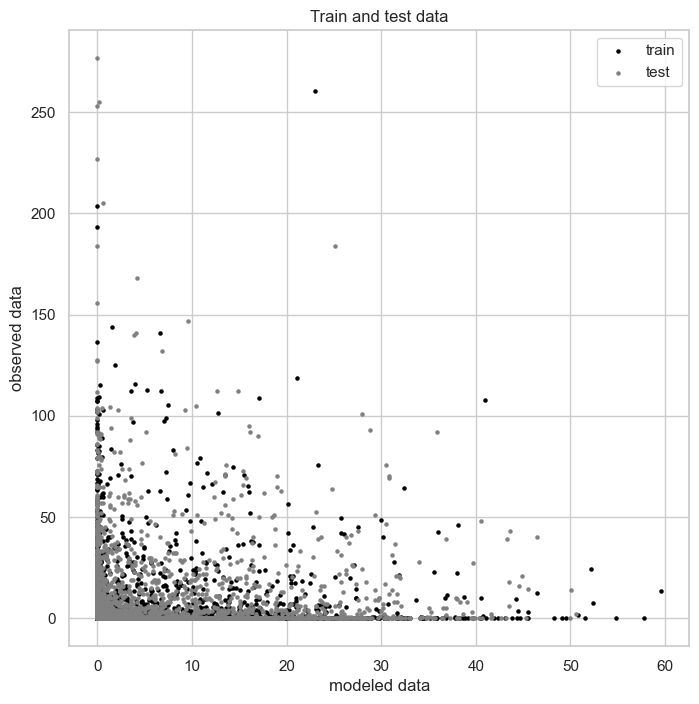

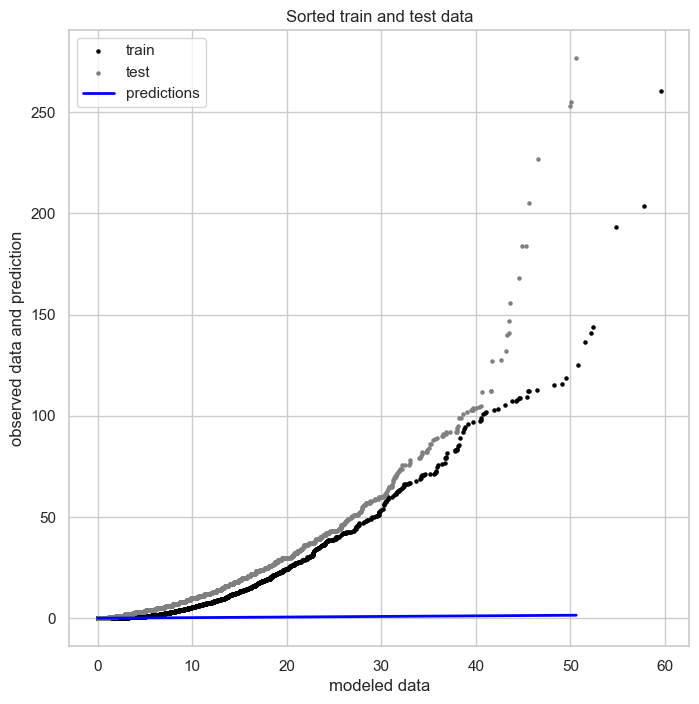

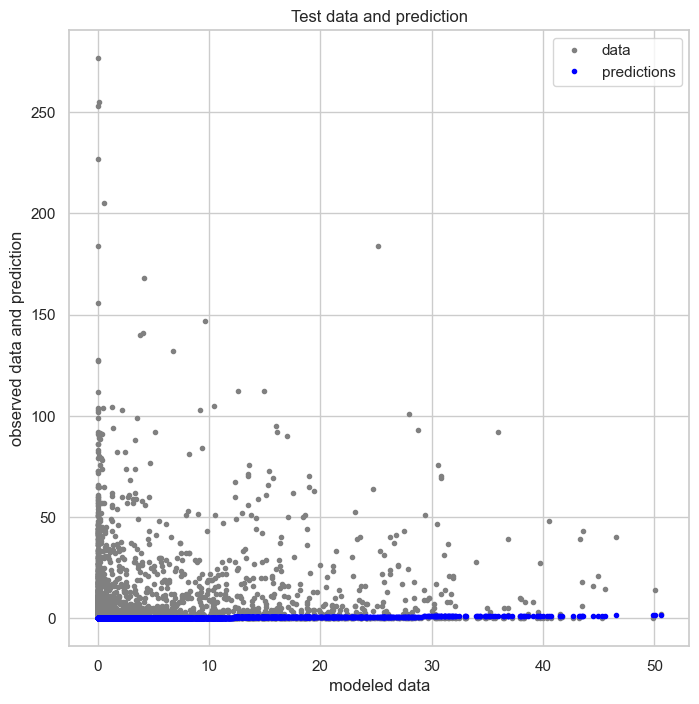

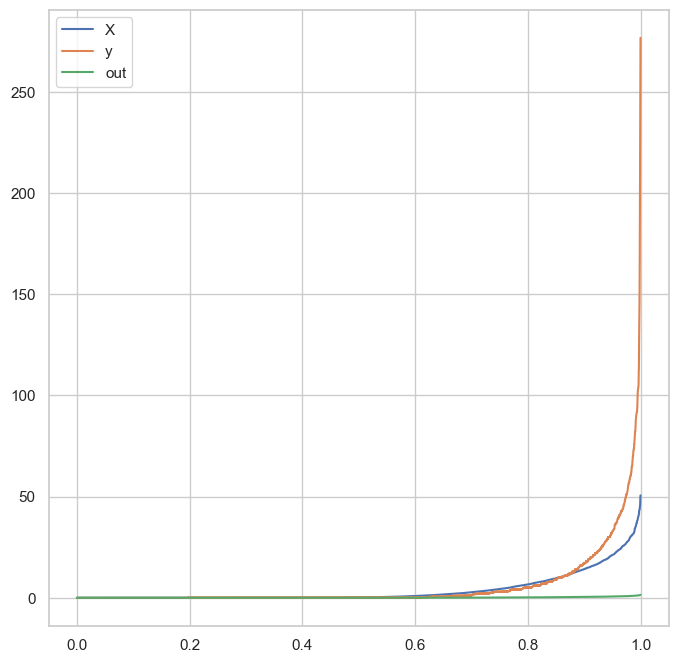

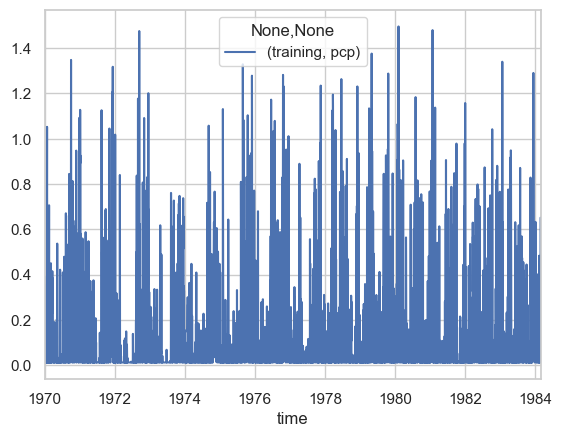

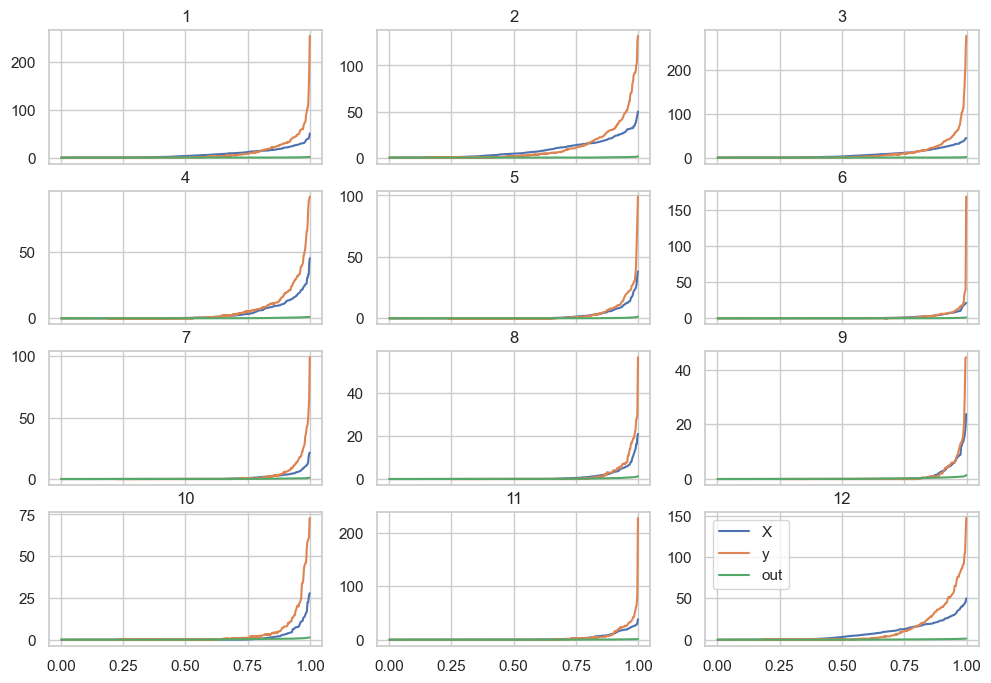

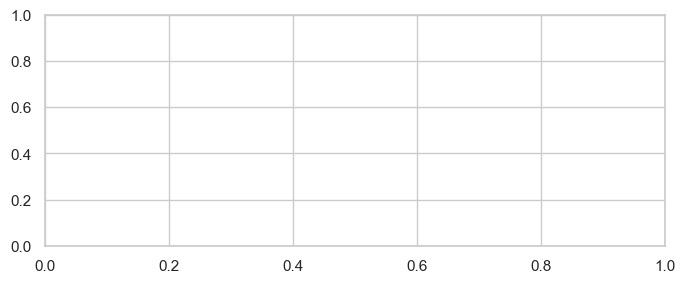

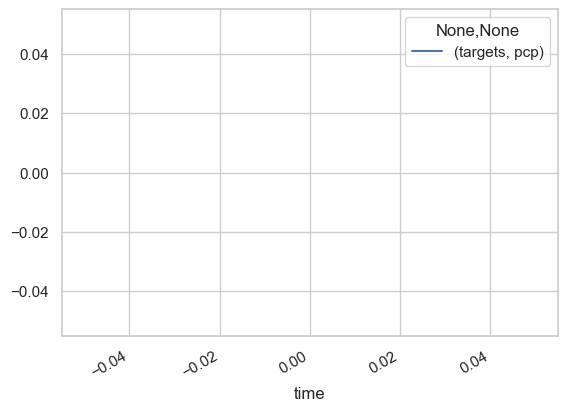

In [40]:
(X_train, X_test, y_train, y_test,pred)=BC('BEIRA, MZ',data_obs_NOAA, 'PRCP' ,climate_var_NEX_GDDP_CMIP6_EmplacementStation[climate_var_NEX_GDDP_CMIP6_EmplacementStation['Model']=='ACCESS-CM2'], 'Mean of the daily precipitation rate mm/day','Quantile_Linear_Regression')

In [24]:
time_slice = slice('1990-01-01', '1990-12-31')

In [38]:
pred

,training
,pcp
time,
1970-01-01,0.391770
1970-01-02,0.187585
1970-01-03,0.269985
1970-01-04,0.152739
1970-01-05,0.351040
...,...
1984-02-24,0.012158
1984-02-25,0.014970


In [ ]:
X_train

In [ ]:
y_train.index

In [ ]:
from mlinsights.mlmodel import QuantileLinearRegression # in quantile_regression
model = QuantileLinearRegression()
model.fit(X_train.values, y_train.values.reshape((len(y_train),)))

In [ ]:
pred = model.predict(X_test.values)

In [ ]:
pred

In [ ]:
out = pd.DataFrame()
out['time'] = y_train.index
out['pcp'] = pred
out = out.set_index('time')

In [ ]:
out.set_index('time')

In [ ]:
# current application of BCSD Precipitation

In [ ]:
climate_var = 'pr' # 'tas'

# precipitation : 'pr'

name_station = 'BEIRA, MZ'

In [ ]:
climate_var_NEX_GDDP_CMIP6_EmplacementStation=import_treat_modeled_NEX_GDDP_CMIP6(climate_var)
data_obs_NOAA=import_treat_obs_NOAA()

In [ ]:
climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC=climate_var_NEX_GDDP_CMIP6_EmplacementStation[climate_var_NEX_GDDP_CMIP6_EmplacementStation['Name station']==name_station].drop(['Name station','Year','Month','Season'],axis =1)
climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC_model = climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC[climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC['Model'] =='ACCESS-CM2'].drop(['Model'],axis=1)
training = climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC_model.rename(columns = {'Date':'time','Mean of the daily precipitation rate mm/day':'pcp'}).reset_index()

# changing format of Date for training
Date1 = training['time'].values
for i in np.arange(0,len(training)):
    training['time'][i] = Date1[i][6:10]+'-'+Date1[i][3:5]+'-'+Date1[i][0:2]#datetime.strptime(, '%Y-%M-%d').date()
    print(training['time'][i])
# .date() to avoid having the hours in the datetime
training=training.set_index('time').drop(['index'],axis=1)


# targets
targets = data_obs_NOAA[['NAME','DATE','PRCP']] # select only 3 columns of interest
targets = targets[targets['NAME']==name_station].rename(columns = {'DATE':'time','PRCP':'pcp'}).set_index('time').drop(['NAME'],axis=1) # the targets data is meant to represent our "observations"


# to have the same size of vectors
targets = targets.dropna() # drop rows with NaN
training = training[training.index.isin(list(targets.index))]

In [ ]:
df=pd.concat({'training': training, 'targets': targets}, axis=1)

df=df.dropna()

In [ ]:
df = df.droplevel(1,axis=1)
df

In [ ]:
out=BCSD_Precipitation(df)

In [ ]:
out

In [ ]:
# return period before first BC
out3 = add_year_month_season(out.reset_index(),'time')
Z=out3.groupby('Year')[['pcp']].max()
(loc1,scale)=stats.gumbel_r.fit(Z) # return the function necessary to establish the continous function
# choice of gumbel because suits to extreme precipitation
#return_period.loc[(name_p,ssp,model),('Value for return period 50 years mm/day')] = 
#threshold_coresponding_to_return_period(loc1,scale,50) ## 113
#return_period.loc[(name_p,ssp,model),('Value for return period 100 years mm/day')] = 
threshold_coresponding_to_return_period(loc1,scale,100) # 124

In [ ]:
out=BCSD_Precipitation_one_more_time(df,out) # second time

In [ ]:
out

In [ ]:
out=BCSD_Precipitation_one_more_time(df,out) # third time

In [ ]:
out

In [ ]:
out=BCSD_Precipitation_one_more_time(df,out) # fourth time

In [ ]:
out3 = add_year_month_season(out.reset_index(),'time')

In [ ]:
out3

In [ ]:
Z=out3.groupby('Year')[['pcp']].max()

In [ ]:
out

In [ ]:
(loc1,scale)=stats.gumbel_r.fit(Z) # return the function necessary to establish the continous function
# choice of gumbel because suits to extreme precipitation
#return_period.loc[(name_p,ssp,model),('Value for return period 50 years mm/day')] = 
threshold_coresponding_to_return_period(loc1,scale,50) ## 220
#return_period.loc[(name_p,ssp,model),('Value for return period 100 years mm/day')] = 
#threshold_coresponding_to_return_period(loc1,scale,100) # 245

In [ ]:
out=BCSD_Precipitation_one_more_time(df,out) # fifth time

In [ ]:
out

In [ ]:
out = add_year_month_season(out.reset_index(),'time')

In [ ]:
Z=out.groupby('Year')[['pcp']].max()

In [ ]:
(loc1,scale)=stats.gumbel_r.fit(Z) # return the function necessary to establish the continous function
# choice of gumbel because suits to extreme precipitation
#return_period.loc[(name_p,ssp,model),('Value for return period 50 years mm/day')] = 
threshold_coresponding_to_return_period(loc1,scale,50) ## 245
#return_period.loc[(name_p,ssp,model),('Value for return period 100 years mm/day')] = 
#threshold_coresponding_to_return_period(loc1,scale,100) # 274